In [1]:
import torch
import torch.nn as nn
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from fydyc_dataset import FydycDataset
import os
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F

class PolynomialRegression(nn.Module):
    def __init__(self, degree):
        super(PolynomialRegression, self).__init__()
        self.degree = degree
        # 对于二次多项式，需要3个参数：x^2, x和常数项
        self.linear = nn.Linear(degree + 1, 1)
    
    def forward(self, x):
        # 生成多项式特征
        poly_features = torch.cat([x ** i for i in range(self.degree + 1)], dim=1)
        # 应用线性层
        return self.linear(poly_features)

        
degree = 2  # 二次多项式
model = PolynomialRegression(degree)
model.load_state_dict(torch.load('fydyc/model32.pth'))


csv_file='fydyc/fydyc_real.csv'
dataset = FydycDataset(csv_file)
data = pd.read_csv(csv_file)


             日期      预测日期     时间     风电预测     光伏预测     火电计划   水电计划      供电预测  \
0      20231110  20231115  01:30   606.34     0.00  14770.0  500.0  11845.05   
1      20231110  20231115  01:45   607.41     0.00  14770.0  500.0  11820.17   
2      20231110  20231115  01:15   607.63     0.00  14770.0  500.0  11907.69   
3      20231110  20231115  02:00   610.83     0.00  14770.0  500.0  11787.99   
4      20231110  20231115  01:00   611.18     0.00  14770.0  500.0  11991.83   
...         ...       ...    ...      ...      ...      ...    ...       ...   
34939  20231201  20231208  11:30  6279.48  2302.79  16600.0  500.0  15463.00   
34940  20231201  20231208  10:30  6377.29  2222.53  16600.0  500.0  15554.78   
34941  20231201  20231208  11:15  6302.62  2313.97  16600.0  500.0  15657.71   
34942  20231201  20231208  10:45  6351.86  2267.99  16600.0  500.0  15664.75   
34943  20231201  20231208  11:00  6326.88  2314.80  16600.0  500.0  15671.52   

       省级断面计划  Unnamed: 9  Unnamed: 10 

/var/folders/0l/n8_y01zn6xs5nr2z3l4vfg240000gn/T/ipykernel_50969/2152517471.py:14: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


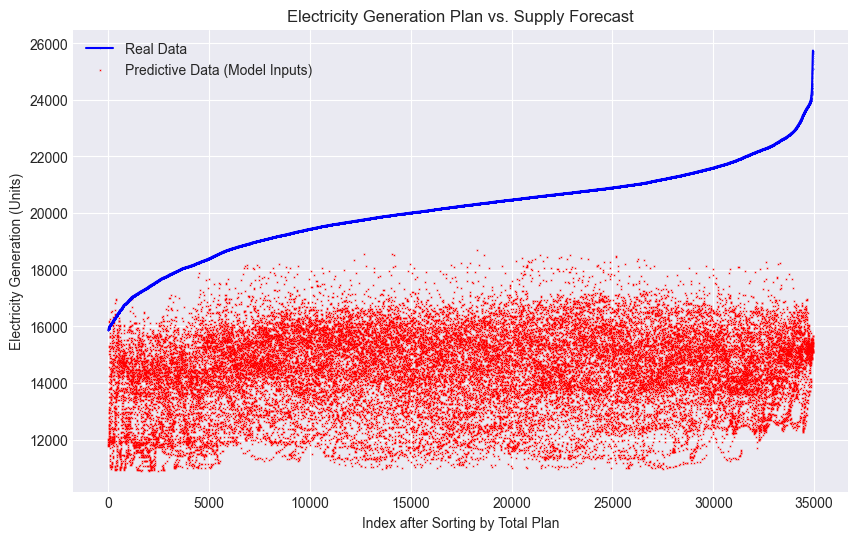

In [2]:


# 计算 "风电预测"、"光伏预测"、"火电计划" 和 "水电计划" 的和
data['total_plan'] = data.apply(lambda row: row['风电预测'] + row['光伏预测'] + row['火电计划'] + row['水电计划'], axis=1)

# 提取 "供电预测" 字段
supply_forecast = data['供电预测']
data['supply_forecast'] = supply_forecast

# 按 'total_plan' 进行排序
data_sorted = data.sort_values(by='total_plan').reset_index(drop=True)
print(data_sorted)


# 设置绘图风格
plt.style.use('seaborn-darkgrid')

# 创建一个新的图形
plt.figure(figsize=(10, 6))

# 绘制 'total_plan' 作为发电量
plt.plot(data_sorted.index, data_sorted['total_plan'], label='Real Data', color='blue', marker='o', linestyle='-', markersize=0.1)

# 使用点图绘制 '供电预测' 作为发电量
plt.scatter(data_sorted.index, data_sorted['supply_forecast'], label='Predictive Data (Model Inputs)', color='red', marker='x', s=0.1)  # s 控制点的大小

# 添加图例
plt.legend()

# 添加标题和坐标轴标签
plt.title("Electricity Generation Plan vs. Supply Forecast")
plt.xlabel("Index after Sorting by Total Plan")
plt.ylabel("Electricity Generation (Units)")

# 显示图形
plt.show()


/var/folders/0l/n8_y01zn6xs5nr2z3l4vfg240000gn/T/ipykernel_50969/1096428357.py:38: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


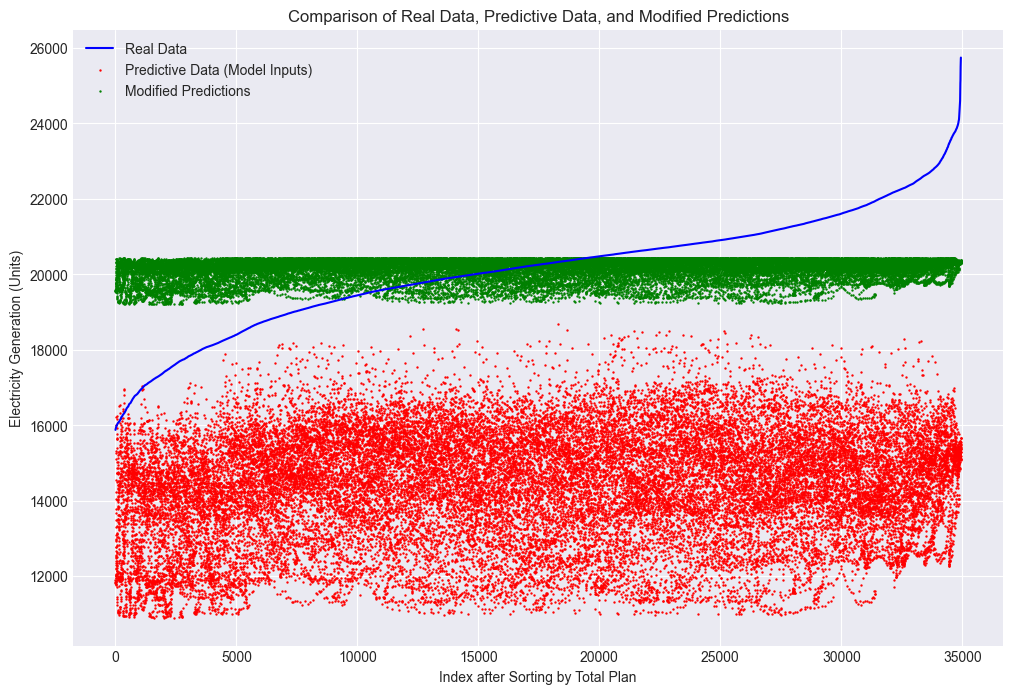

In [3]:
import torch
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

# 假设 data, dataset.scaler_features, dataset.scaler_labels, model 已经准备好

# 初始化一个列表来存储预测值
predicted_values = []

# 遍历 '供电预测' 中的每个值
for value in data_sorted['supply_forecast']:
    # 将当前值标准化
    normalized_value = dataset.scaler_features.transform([[value]])
    input_tensor = torch.from_numpy(normalized_value).float()
    input_tensor = input_tensor.view(1, -1)  # 确保其形状与模型输入的形状相匹配

    # 不需要计算梯度
    with torch.no_grad():
        output_tensor = model(input_tensor)
        
    # 将输出张量转换为 numpy 数组并进行逆标准化
    output_value = output_tensor.numpy() 
    predicted_value = dataset.scaler_labels.inverse_transform(output_value)
    
    # 将预测值添加到列表中
    predicted_values.append(predicted_value[0][0])
    
# 确保predicted_values_sorted是一个Pandas Series，如果不是，可以通过下面的代码转换
predicted_values = pd.Series(predicted_values)

# 将预测值添加到排序后的DataFrame中
data_sorted['Modified_Predictions'] = predicted_values.values

# 现在，data_sorted已经包含了"Modified Predictions"字段，接下来可以绘图来比较实际数据、预测数据和修正后的预测数据

# 设置绘图风格
plt.style.use('seaborn-darkgrid')

# 创建一个新的图形
plt.figure(figsize=(12, 8))

# 绘制 'total_plan' 作为实际发电量
plt.plot(data_sorted.index, data_sorted['total_plan'], label='Real Data', color='blue', linestyle='-')

# 绘制 '供电预测' 作为预测发电量
plt.scatter(data_sorted.index, data_sorted['supply_forecast'], label='Predictive Data (Model Inputs)', color='red', s=0.5)

# 绘制修正后的预测值
plt.scatter(data_sorted.index, data_sorted['Modified_Predictions'], label='Modified Predictions', color='green', s=0.5)

# 添加图例
plt.legend()

# 添加标题和坐标轴标签
plt.title("Comparison of Real Data, Predictive Data, and Modified Predictions")
plt.xlabel("Index after Sorting by Total Plan")
plt.ylabel("Electricity Generation (Units)")

# 显示图形
plt.show()


/var/folders/0l/n8_y01zn6xs5nr2z3l4vfg240000gn/T/ipykernel_50969/2628132998.py:38: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


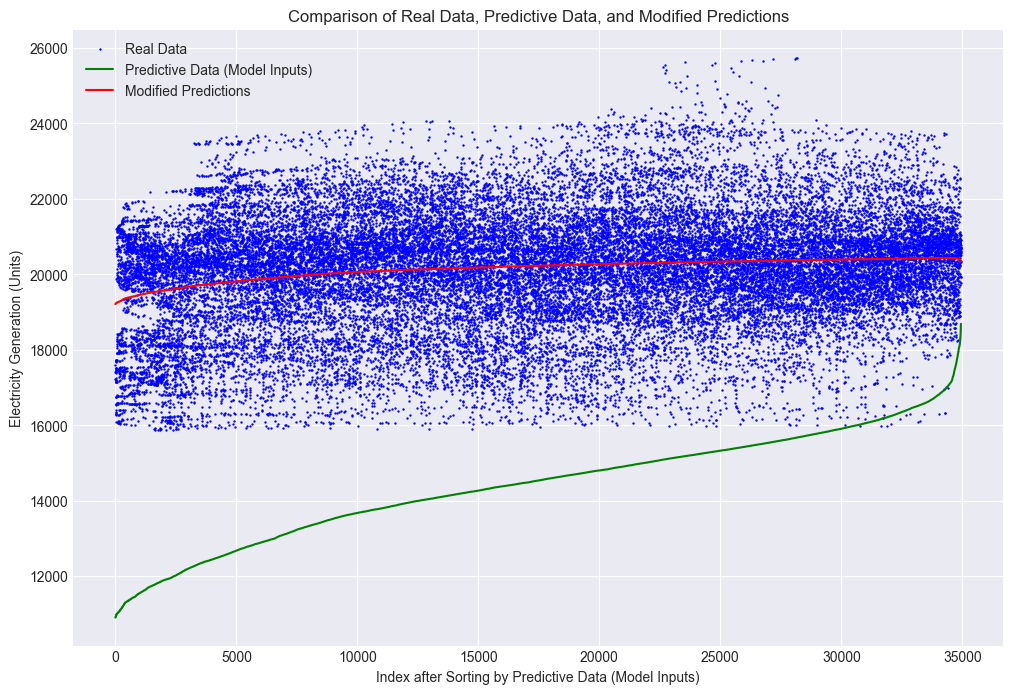

In [6]:
import torch
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

# 假设 data, dataset.scaler_features, dataset.scaler_labels, model 已经准备好

# 初始化一个列表来存储预测值
predicted_values = []
data_sorted = data_sorted.sort_values(by='supply_forecast').reset_index(drop=True)
# 遍历 '供电预测' 中的每个值
for value in data_sorted['supply_forecast']:
    # 将当前值标准化
    normalized_value = dataset.scaler_features.transform([[value]])
    input_tensor = torch.from_numpy(normalized_value).float()
    input_tensor = input_tensor.view(1, -1)  # 确保其形状与模型输入的形状相匹配

    # 不需要计算梯度
    with torch.no_grad():
        output_tensor = model(input_tensor)
        
    # 将输出张量转换为 numpy 数组并进行逆标准化
    output_value = output_tensor.numpy() 
    predicted_value = dataset.scaler_labels.inverse_transform(output_value)
    
    # 将预测值添加到列表中
    predicted_values.append(predicted_value[0][0])
    
# 确保predicted_values_sorted是一个Pandas Series，如果不是，可以通过下面的代码转换
predicted_values = pd.Series(predicted_values)

# 将预测值添加到排序后的DataFrame中
data_sorted['Modified_Predictions'] = predicted_values.values

# 现在，data_sorted已经包含了"Modified Predictions"字段，接下来可以绘图来比较实际数据、预测数据和修正后的预测数据

# 设置绘图风格
plt.style.use('seaborn-darkgrid')

# 创建一个新的图形
plt.figure(figsize=(12, 8))

# 绘制 'total_plan' 作为实际发电量
plt.scatter(data_sorted.index, data_sorted['total_plan'], label='Real Data', color='blue', s=0.5)

# 绘制 '供电预测' 作为预测发电量
plt.plot(data_sorted.index, data_sorted['supply_forecast'], label='Predictive Data (Model Inputs)', color='green',  linestyle='-')

# 绘制修正后的预测值
plt.plot(data_sorted.index, data_sorted['Modified_Predictions'], label='Modified Predictions', color='red', linestyle='-')

# 添加图例
plt.legend()

# 添加标题和坐标轴标签
plt.title("Comparison of Real Data, Predictive Data, and Modified Predictions")
plt.xlabel("Index after Sorting by Predictive Data (Model Inputs)")
plt.ylabel("Electricity Generation (Units)")

# 显示图形
plt.show()


In [5]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# 假设 dataset.scaler_features 已经适配过数据

total_plan_sorted=data['total_plan']
total_plan_normalized = dataset.scaler_features.transform(total_plan_sorted.values.reshape(-1, 1)).flatten()

# 确保 'predicted_values' 是基于归一化输入计算的预测值
# 如果 'predicted_values' 还未归一化，你需要根据实际情况调整

# 计算修正前预测值（归一化的 'supply_forecast'）相对于归一化真实值的MSE
mse_before_normalized = mean_squared_error(total_plan_normalized, dataset.scaler_features.transform(supply_forecast.values.reshape(-1, 1)).flatten())

# 计算修正后预测值（归一化的 'predicted_values'）相对于归一化真实值的MSE
mse_after_normalized = mean_squared_error(total_plan_normalized, dataset.scaler_features.transform(np.array(predicted_values).reshape(-1, 1)).flatten())

# 计算RMSE
rmse_before_normalized = np.sqrt(mse_before_normalized)
rmse_after_normalized = np.sqrt(mse_after_normalized)

# 计算MAE
mae_before_normalized = mean_absolute_error(total_plan_normalized, dataset.scaler_features.transform(supply_forecast.values.reshape(-1, 1)).flatten())
mae_after_normalized = mean_absolute_error(total_plan_normalized, dataset.scaler_features.transform(np.array(predicted_values).reshape(-1, 1)).flatten())

print(f"MSE before modification (normalized): {mse_before_normalized}")
print(f"MSE after modification (normalized): {mse_after_normalized}")
print(f"RMSE before modification (normalized): {rmse_before_normalized}")
print(f"RMSE after modification (normalized): {rmse_after_normalized}")
print(f"MAE before modification (normalized): {mae_before_normalized}")
print(f"MAE after modification (normalized): {mae_after_normalized}")


MSE before modification (normalized): 0.596967292799313
MSE after modification (normalized): 0.03513372499762559
RMSE before modification (normalized): 0.7726365852063395
RMSE after modification (normalized): 0.18743992370257087
MAE before modification (normalized): 0.7334333328936575
MAE after modification (normalized): 0.14654176488076145
